<a href="https://colab.research.google.com/github/Momina-Hussnain/Elvvo-Internship-Task-2/blob/main/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta

df = pd.read_csv("online_sales_dataset (1).csv", encoding="latin1", delimiter=",", on_bad_lines='skip')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00,1.71,37039.0,Australia,0.470000,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00,41.25,19144.0,Spain,0.190000,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00,29.11,50472.0,Germany,0.350000,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00,76.68,96586.0,Netherlands,0.140000,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low
4,359178,SKU_1386,USB Cable,-30,2020-01-01 04:00,-68.11,NaN,United Kingdom,1.501433,Bank Transfer,NaN,Electronics,In-store,Not Returned,FedEx,NaN,Medium


In [15]:
df_clean = df.dropna(subset=["CustomerID", "InvoiceDate"]).copy()
df_clean["InvoiceDate"] = pd.to_datetime(df_clean["InvoiceDate"], errors="coerce")
df_clean = df_clean.dropna(subset=["InvoiceDate"])

df_clean["InvoiceNo"] = df_clean["InvoiceNo"].astype(str).str.strip()
df_clean = df_clean[~df_clean["InvoiceNo"].str.startswith("C")]

df_clean["Quantity"] = pd.to_numeric(df_clean["Quantity"], errors="coerce").fillna(0)
df_clean["UnitPrice"] = pd.to_numeric(df_clean["UnitPrice"], errors="coerce").fillna(0)

df_clean["TotalAmount"] = df_clean["Quantity"] * df_clean["UnitPrice"]
df_clean = df_clean[df_clean["TotalAmount"] > 0]

df_clean.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Discount,PaymentMethod,ShippingCost,Category,SalesChannel,ReturnStatus,ShipmentProvider,WarehouseLocation,OrderPriority,TotalAmount
0,221958,SKU_1964,White Mug,38,2020-01-01 00:00:00,1.71,37039.0,Australia,0.47,Bank Transfer,10.79,Apparel,In-store,Not Returned,UPS,London,Medium,64.98
1,771155,SKU_1241,White Mug,18,2020-01-01 01:00:00,41.25,19144.0,Spain,0.19,paypall,9.51,Electronics,Online,Not Returned,UPS,Rome,Medium,742.50
2,231932,SKU_1501,Headphones,49,2020-01-01 02:00:00,29.11,50472.0,Germany,0.35,Bank Transfer,23.03,Electronics,Online,Returned,UPS,Berlin,High,1426.39
3,465838,SKU_1760,Desk Lamp,14,2020-01-01 03:00:00,76.68,96586.0,Netherlands,0.14,paypall,11.08,Accessories,Online,Not Returned,Royal Mail,Rome,Low,1073.52
5,744167,SKU_1006,Office Chair,47,2020-01-01 05:00:00,70.16,53887.0,Sweden,0.48,Credit Card,13.98,Electronics,Online,Not Returned,DHL,London,Medium,3297.52


In [16]:
snapshot_date = df_clean["InvoiceDate"].max() + timedelta(days=1)
snapshot_date


Timestamp('2025-09-06 05:00:00')

In [17]:
rfm = (
    df_clean.groupby("CustomerID")
    .agg(
        Recency=("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
        Frequency=("InvoiceNo", "nunique"),
        Monetary=("TotalAmount", "sum"),
    )
    .reset_index()
)
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,10001.0,742,1,1516.22
1,10003.0,1842,1,377.05
2,10005.0,251,2,2527.15
3,10008.0,145,1,62.60
4,10009.0,1826,1,827.84


In [18]:
rfm["R_Score"] = pd.qcut(rfm["Recency"].rank(method="first"), 5, labels=[5,4,3,2,1])
rfm["F_Score"] = pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])
rfm["M_Score"] = pd.qcut(rfm["Monetary"].rank(method="first"), 5, labels=[1,2,3,4,5])

rfm["RFM_Score"] = (
    rfm["R_Score"].astype(str) + rfm["F_Score"].astype(str) + rfm["M_Score"].astype(str)
)
rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,10001.0,742,1,1516.22,3,1,3,313
1,10003.0,1842,1,377.05,1,1,2,112
2,10005.0,251,2,2527.15,5,4,4,544
3,10008.0,145,1,62.60,5,1,1,511
4,10009.0,1826,1,827.84,1,1,2,112


In [19]:
def segment_customer(row):
    r, f, m = int(row["R_Score"]), int(row["F_Score"]), int(row["M_Score"])
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    if r >= 3 and f >= 4:
        return "Loyal"
    if r <= 2 and f >= 3 and m >= 3:
        return "Potential Loyalist"
    if r <= 2 and f <= 2 and m <= 2:
        return "At Risk"
    if r == 1 and f == 1 and m == 1:
        return "Lost"
    return "Others"

rfm["Segment"] = rfm.apply(segment_customer, axis=1)
rfm["Segment"].value_counts()


,count
Segment,
Others,18079
Loyal,5630
Potential Loyalist,4570
Champions,4056
At Risk,3054


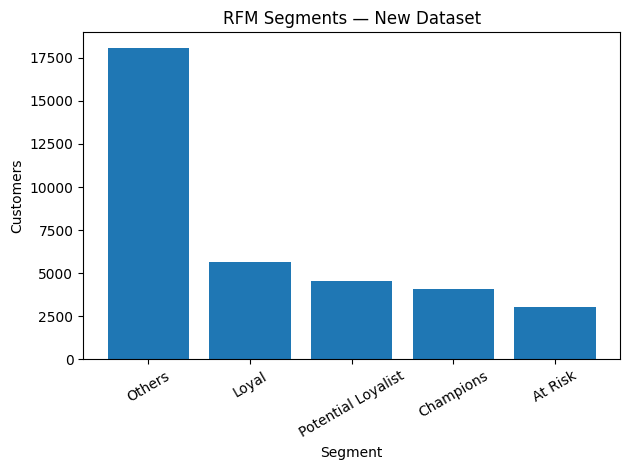

In [20]:
counts = rfm["Segment"].value_counts()
plt.figure()
plt.bar(counts.index, counts.values)
plt.title("RFM Segments — New Dataset")
plt.xlabel("Segment")
plt.ylabel("Customers")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


In [21]:
rfm.to_csv("RFM_table_newdata.csv", index=False)
df_clean.to_csv("online_sales_clean.csv", index=False)
